In [1]:
# 注:
# 在使用SANet时:
# img_size, gt_size = (448, 448), (448, 448)
# 在使用MCNN时:
# img_size, gt_size = (448, 448), (112, 112)
# 原因是，MCNN中仅有特征提取，而SANet中引入了反卷积

In [2]:
#===========================================================================================
# 解压文件，生成预处理文件
#===========================================================================================

# 在new_util.py中定义了处理上海tech数据集的预处理函数
import new_util
from new_util import deal_ShanghaiTech_Crowd_Counting_Dataset_mat as deal_mat

# 解压文件数据，并在当前目录生成预处理txt文件
new_util.pre_ShanghaiTech_Crowd_Counting_Dataset('data/data21781/Shanghai.zip', sign='train')
new_util.pre_ShanghaiTech_Crowd_Counting_Dataset('data/data21781/Shanghai.zip', sign='test')

In [3]:
#===========================================================================================
# 该函数用于检验图像标注
#===========================================================================================
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def img_show(img_path, gt_path):
    '''
    img_path : 上海tech数据集中，图片的路径
    gt_path  : 上海tech数据集中，标注的路径
    '''

    # 读取照片
    img = mpimg.imread(img_path)
    plt.imshow(img)
    # 读取坐标和人数
    coo, num = deal_mat(gt_path)
    # 画坐标点
    plt.scatter(coo[:, 0],coo[:, 1], color='r', marker='o', edgecolors='w', s=20)
    plt.axis('off')
    plt.show()

i = 250
img_path = 'data/data21781/Shanghai/part_A_final/train_data/images/IMG_%s.jpg' % i
gt_path = 'data/data21781/Shanghai/part_A_final/train_data/ground_truth/GT_IMG_%s.mat' % i
img_show(img_path, gt_path)

<Figure size 640x480 with 1 Axes>

In [4]:
#===========================================================================================
# 图片放缩，其标注跟着放缩
#===========================================================================================
from PIL import Image
import numpy as np

def img_resize(img_path, gt_path, new_size):
    '''
    输入:
        img_path : 上海tech数据集中，图片的路径
        gt_path  : 上海tech数据集中，标注的路径
        new_size : 想要缩放的大小

    返回:
        new_img  : 被缩放后的图片
        coo      : 缩放后的坐标
        num      : 图片中的人数
    '''

    # 读取图片
    img = Image.open(img_path)

    if img.mode != 'RGB': 
        img = img.convert('RGB')

    # 获得大小, 正好是宽高
    old_size = img.size
    # 图片resize
    new_img = img.resize(new_size)

    # 读取标注
    coo, num = deal_mat(gt_path)
    coo = coo / old_size * new_size

    return new_img, coo, num

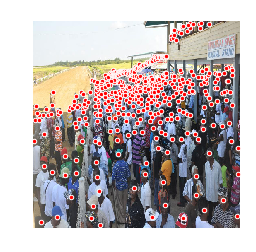

In [5]:
#===========================================================================================
# 检验放缩后，标注是否正确
#===========================================================================================
def check(img, coo):
    '''
    img, coo 均为上一个函数的返回值
    '''
    # 将PIL的img数据做转换
    img = np.array(img)
    plt.imshow(img)
    # 绘制坐标
    plt.scatter(coo[:, 0],coo[:, 1], color='r', marker='o', edgecolors='w', s=20)

    plt.axis('off')
    plt.show()

new_size = 500, 500
img, coo, num = img_resize(img_path, gt_path, new_size)
check(img, coo)

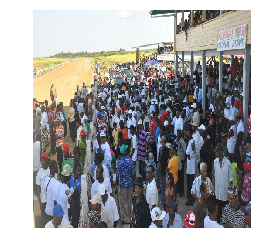

In [6]:
plt.imshow(img)
plt.axis('off')
plt.show()

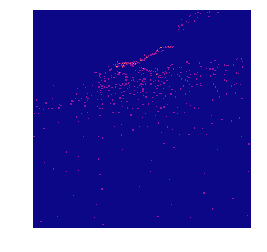

密度图人数 472 
实际人数 472


In [7]:
#===========================================================================================
# 定义读取数据函数————计算d_avg函数
#===========================================================================================
import cv2
def calc_d_avg(annotation, k):
    # 该函数用于计算d平均, 之后函数会调用
    '''
    annotation : 人头点的坐标
    k          : 取k个人
    '''

    d_avg_list = []
    for i, coor in enumerate(annotation):
        # 计算距离
        dis = np.linalg.norm(annotation - coor, axis=1)
        # 距离从小到大排序(.sort为原地操作)
        dis.sort() 
        if k+1 <= len(dis):
            # 取前k+1个
            d_arg = np.sum(dis[:k+1]) / k
        else:
            d_arg = np.sum(dis) / (len(dis)-1)

        d_avg_list.append(d_arg)

    return np.array(d_avg_list)

#===========================================================================================
# 定义读取数据函数————获得标签函数,
#===========================================================================================
def get_label(annotation, size, beta=0.3, k=10):
    # 该函数用于获取 `ground Truth`
    '''
    annotation : 坐标
    size       : ground True的大小
    beta       : 论文中的`beta`值
    '''
    # print(annotation, size)

    # 计算每个点的d_avg
    d_avg = calc_d_avg(annotation, k)

    # 创建模板
    tempelate = np.zeros(size[::-1])

    for i, coor in enumerate(annotation):
        
        try:
            # 由于数据标注中存在脏数据，会产生`IndexError`, 故而这样操作

            # 创建当前坐标的冲激函数
            new = np.zeros(size[::-1])
            # 当前坐标
            x, y = coor[::-1] # 数组里边的坐标要反一下, 第x行，第y列
            x, y = int(x), int(y)
            # 得到冲激函数
            new[x][y] = 1 
            # 根据公式求sigma
            sigma = beta * d_avg[i]
            # 对图片进行SAME卷积操作
            new = cv2.GaussianBlur(new, (3, 3), sigma) # 猜测 borderType 是 SAME
            # 加到原图上
            tempelate += new

        except IndexError:
            continue

    return tempelate


# 绘制`ground True`密度图
gt = get_label(coo, new_size)
plt.imshow(gt, cmap='plasma')
plt.axis('off')
plt.show()
# 可能会一定程度上不相等
print('密度图人数', int(np.sum(gt)), '\n实际人数', num)

In [ ]:
#===========================================================================================
# 定义读取数据函数————自定义reader
#===========================================================================================
def custom_reader(img_txt_path, gt_txt_path, img_size, gt_size):
    '''
    img_txt_path  :  之前预处理之后的img_path的txt
    gt_txt_path   :  之前预处理之后的gt_path的txt
    img_size      :  图片缩放后的大小
    gt_size       :  gt的大小
    '''
    with open(img_txt_path) as f:
        img_list = f.readlines()
        img_list = [path.replace('\n', '') for path in img_list]
    with open(gt_txt_path) as g:
        gt_list = g.readlines()
        gt_list = [path.replace('\n', '') for path in gt_list]

    def reader():
        
        for img_path, gt_path in zip(img_list, gt_list):
            
            # 图片缩放
            img, coo, num = img_resize(img_path, gt_path, img_size)
            # 通道数置于最前面
            img = np.array(img)
            img = img.transpose((2, 0, 1))
            # 归一化
            img = img / 255
            
            # 获取坐标和人数
            _, coo, _ = img_resize(img_path, gt_path, gt_size)

            gt = get_label(coo, gt_size)


            yield img, gt, num
    
    return reader



#===========================================================================================
# 定义读取数据函数————自定义reader
#===========================================================================================
import paddle
train_img_txt_path, train_gt_txt_path, img_size, gt_size = 'A_train_img.txt', 'A_train_gt.txt', (448, 448), (112, 112)
test_img_txt_path, test_gt_txt_path = 'A_test_img.txt', 'A_test_gt.txt'

# 用于训练的数据提供器
shuffle_reader = paddle.reader.shuffle(reader=custom_reader(train_img_txt_path, train_gt_txt_path, img_size, gt_size), buf_size=64)
train_reader = paddle.batch(shuffle_reader,
                            batch_size=16,
                            drop_last=False)
# 用于测试的数据提供器
eval_reader = paddle.batch(custom_reader(test_img_txt_path, test_gt_txt_path, img_size, gt_size),
                            batch_size=8,
                            drop_last=False)

In [14]:
#===========================================================================================
# 模型校验函数
#===========================================================================================
def model_test(model):

    with fluid.dygraph.guard():

        # 开启评估模式
        model.eval()

        # 错误率
        mistake_rate = []
        for batch_id, data in enumerate(eval_reader()):

            # 原始图片
            img_raw = np.array([x[0] for x in data]).astype('float32')
            # 标签人流密度图
            img_lab = np.array([x[1] for x in data]).astype('float32')
            img_lab = img_lab[:, np.newaxis]
            # 标签人数
            number_lab = np.array([x[2] for x in data]).astype('int32')


            # 转化为paddle的类型
            img_raw = fluid.dygraph.to_variable(img_raw)
            img_lab = fluid.dygraph.to_variable(img_lab)
            number_lab = fluid.dygraph.to_variable(number_lab)

            out = model(img_raw)
            
            #########################
            # 计算错误率
            #       | P_i - G_i |
            # E_i = --------------
            #            G_i
            #########################
            
            Gi = number_lab.numpy()
            Pi = np.array([np.sum(den_pic) for den_pic in out.numpy()])
            mistake_rate_numerator = np.abs(Pi - Gi)
            Ei = np.mean(mistake_rate_numerator / Gi)
            mistake_rate.append(Ei)

    return np.mean(mistake_rate)

In [ ]:
#===========================================================================================
# 模型训练
#===========================================================================================
from paddle.fluid.dygraph import Pool2D, Conv2D, Linear, Conv2DTranspose
from paddle.fluid.layers import concat, stack
import paddle.fluid as fluid


from MCNN import MCNN

LOAD_MODEL = True # 是否加载旧模型
try:
    with fluid.dygraph.guard():
        
        model = MCNN() #模型实例化
        
        if LOAD_MODEL:
            # 从本地加载参数
            model_para, _ = fluid.load_dygraph('MCNN')
            # 加载参数
            model.load_dict(model_para)

        base_lr = 0.001
        learning_rate = fluid.layers.exponential_decay(
                                learning_rate=base_lr,
                                decay_steps=600,
                                decay_rate=0.2,
                                staircase=True)
        optimizer = fluid.optimizer.AdamOptimizer(learning_rate=learning_rate, parameter_list=model.parameters())
        
        model.train() #训练模式

        epochs_num = 30
        loss_list = [] # 损失列表
        train_err = [] # 训练集错误率列表
        test_err = [] # 测试集错误率列表
        
        for epoch_num in range(epochs_num):
            
            for batch_id, data in enumerate(train_reader()):

                # 原照片
                img_raw = np.array([x[0] for x in data]).astype('float32')
                # 密度图标签
                img_lab = np.array([x[1] for x in data]).astype('float32')
                img_lab = img_lab[:, np.newaxis]
                # 标签人数
                number_lab = np.array([x[2] for x in data]).astype('float32')

                #将Numpy转换为DyGraph接收的输入
                img_raw = fluid.dygraph.to_variable(img_raw)
                img_lab = fluid.dygraph.to_variable(img_lab)
                number_lab = fluid.dygraph.to_variable(number_lab)

                # 模型预测
                # 预训练时, 将第二个参数参数改为: 'L', 'M', 'S'
                out = model(img_raw) # 返回了密度图和人数预测

                
                # 均方误差为loss
                loss_sec = fluid.layers.square_error_cost(out, img_lab) # shape = [N, 1, X, X]
                avg_loss_sec = fluid.layers.mean(loss_sec)              # shape = [1]


                #使用backward()方法可以执行反向网络
                avg_loss_sec.backward()
                optimizer.minimize(avg_loss_sec)
        
                #将参数梯度清零以保证下一轮训练的正确性
                model.clear_gradients()
                
                print('batch_id:', batch_id)

                #########################
                # 计算错误率:
                #       | P_i - G_i |
                # E_i = --------------
                #            G_i
                #########################

                Gi = number_lab.numpy()
                Pi = np.array([np.sum(den_pic) for den_pic in out.numpy()])
                mistake_rate_numerator = np.abs(Pi - Gi)
                Ei = np.mean(mistake_rate_numerator / Gi)

                test_Ei = model_test(model)

                loss_list.append(avg_loss_sec.numpy()[0]) # 损失列表
                train_err.append(Ei)                      # 训练集错误率列表
                test_err.append(test_Ei)                  # 测试集错误率列表

                if batch_id % 15 == 0:
                    print("Loss at epoch {}\tstep {}\t错误率:{:.5f}%\tloss:{:.5f}\t测试集错误率:{:.5f}%".format(epoch_num, 
                                                                                                             batch_id, 
                                                                                                             Ei, 
                                                                                                             avg_loss_sec.numpy()[0], 
                                                                                                             test_Ei))
    
        
        # 保存模型参数
        fluid.save_dygraph(model.state_dict(), "MCNN")   
        print("Final loss: {}".format(avg_loss_sec.numpy())) 

except KeyboardInterrupt:
    # 保存模型参数
    fluid.save_dygraph(model.state_dict(), "MCNN")   
    print("Final loss: {}".format(avg_loss_sec.numpy())) 

batch_id: 0
Loss at epoch 0	step 0	错误率:0.88159%	loss:0.01745	测试集错误率:0.58545%
batch_id: 1


In [ ]:
#===========================================================================================
# 绘制错误率图
#===========================================================================================
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname=r'SimHei.ttf') # 设置字体

plt.xlabel("iter", fontsize=43, fontproperties=myfont)
plt.ylabel('错误率', fontsize=43, fontproperties=myfont)

# plt.plot(loss_list, label='loss') 
plt.plot(train_err, label='train_err') 
plt.plot(test_err, label='test_err') 
plt.legend()
plt.grid()
plt.show()

In [ ]:
#===========================================================================================
# 绘制loss图
#===========================================================================================
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname=r'SimHei.ttf') # 设置字体

plt.xlabel("iter", fontsize=43, fontproperties=myfont)
plt.ylabel('loss', fontsize=43, fontproperties=myfont)

plt.plot(loss_list, label='loss') 
plt.legend()
plt.grid()
plt.show()

In [17]:
#===========================================================================================
# 模型校验
#===========================================================================================
with fluid.dygraph.guard():

    # 从本地加载模型
    model_para, _ = fluid.load_dygraph('MCNN')
    # NEW 模型对象
    model = MCNN()
    # 加载参数
    model.load_dict(model_para)
    # 开启评估模式
    model.eval()

    # 错误率
    mistake_rate = []
    for batch_id, data in enumerate(eval_reader()):

        # 原始图片
        img_raw = np.array([x[0] for x in data]).astype('float32')
        # 标签人流密度图
        img_lab = np.array([x[1] for x in data]).astype('float32')
        img_lab = img_lab[:, np.newaxis]
        # 标签人数
        number_lab = np.array([x[2] for x in data]).astype('int32')


        # 转化为paddle的类型
        img_raw = fluid.dygraph.to_variable(img_raw)
        img_lab = fluid.dygraph.to_variable(img_lab)
        number_lab = fluid.dygraph.to_variable(number_lab)

        out = model(img_raw)
        
        #########################
        # 计算错误率
        #       | P_i - G_i |
        # E_i = --------------
        #            G_i
        #########################

        Gi = number_lab.numpy()
        Pi = np.array([np.sum(den_pic) for den_pic in out.numpy()])
        mistake_rate_numerator = np.abs(Pi - Gi)
        Ei = np.mean(mistake_rate_numerator / Gi)
        mistake_rate.append(Ei)

print('平均错误率:', np.mean(mistake_rate))

In [ ]:
#===========================================================================================
# 任意一张图片获得其预测密度图
#===========================================================================================
def get_img(img_path, gt_path, img_size, gt_size):

    # 图片缩放
    img, coo, num = img_resize(img_path, gt_path, img_size)
    # 通道数置于最前面
    img = np.array(img)
    img = img.transpose((2, 0, 1))
    # 归一化
    img = img / 255
    
    # 获取坐标和人数
    _, coo, _ = img_resize(img_path, gt_path, gt_size)
    gt = get_label(coo, gt_size)

    return np.array([img], dtype=np.float32), np.array([[gt]], dtype=np.float32), num



with fluid.dygraph.guard():

    # # 从本地加载模型
    # model_para, _ = fluid.load_dygraph('MCNN')
    # # NEW 模型对象
    # model = MCNN()
    # # 加载参数
    # model.load_dict(model_para)
    # 开启评估模式
    model.eval()

    img_raw, img_lab, number_lab = get_img(img_path, gt_path, img_size, gt_size)

    img_raw = fluid.dygraph.to_variable(img_raw)
    img_lab = fluid.dygraph.to_variable(img_lab)
    # number_lab = fluid.dygraph.to_variable(number_lab)

    out = model(img_raw).numpy()

    plt.imshow(out[0][0], cmap='plasma')
    plt.axis('off')
    plt.show()